In [3]:
import numpy as np
import pandas as pd
import yfinance as yf

<p style="text-align:center; font-size:x-large; color:black;">AR(p) Models</p>
<hr>


In this file, I will try to fit an __Auto-Regressive (AR)__ model on the trading volumes of T-Mobile (NYSE: TMUS). High trading volume generally indicates increased market activity and interest in a particular asset, so it may be of use if we can predict what trading volumes are going to be. <br><br>
Before going further, I am going to grab some stock data with the YahooFinance API. 

In [16]:
msft = yf.Ticker("TMUS")
data = msft.history(period="3y")
data = data.drop(columns = ['Open', 'High', 'Low', 'Close', 'Dividends', 'Stock Splits'])
data

,Volume
Date,
2021-04-20 00:00:00-04:00,3332400
2021-04-21 00:00:00-04:00,3368400
2021-04-22 00:00:00-04:00,3324500
2021-04-23 00:00:00-04:00,3020100
2021-04-26 00:00:00-04:00,2721700
...,...
2024-04-15 00:00:00-04:00,4494600
2024-04-16 00:00:00-04:00,3810400
2024-04-17 00:00:00-04:00,4098300


An AR model is a type of time series model where the current value is based on its previous values. We can imagine it as a multiple (or single) linear regression, where our predictor variables are previous values. The lag __p__ denotes how many past values we are using at predictors for this regression. In equational form, an AR(p) model is the following...

$$
r_{t} = \phi_{0} + \phi_{1}r_{t-1} + \phi_{2}r_{t-1} + \cdots + \phi_{p}r_{t-p} + \epsilon_{t}
$$

&epsilon;<sub>t</sub> is a random value drawn from a __White Noise__ process. a white noise process is a sequence of random variables with mean 0 and finite variance, that have no correlation between successive values. In other words, there is no way of predicting &epsilon;<sub>t</sub>. We can imagine this as the residual of our linear regression. <br><br>
An assumption behind AR models, as well as other linear time-series models like MA and ARMA models is __weak stationarity__. This means that the mean and variance of our time series is invariant of the time. In other words,
$$
E[r_{t}] = E[r_{t - 1}] = E[r_{t - 2}] = \cdots
$$
$$
var[r_{t}] = var[r_{t - 1}] = var[r_{t - 2}] = \cdots
$$
With the assumption of weak stationarity, we can develop an overall expecation and variance for r<sub>t</sub> through some derivations.
$$
E[r_{t}] = \frac{\phi_{0}}{\phi_{1} + \phi_{2} + \cdots + \phi_{p}}
$$
$$
Var[r_t] = \frac{\sigma_{\epsilon}^{2}}{1 - \phi_{1}^{2} - \phi_{2}^{2} - \cdots - \phi_{p}^{2}}
$$
Since our model coefficients aren't changing, the mean and variance of our AR process are constant over time.

Since we are trying to model our time series with a weak stationary process, the time-series that we are trying to model should be weak stationary as well. We can plot our time-series to check if the assumption of weak stationarity holds.

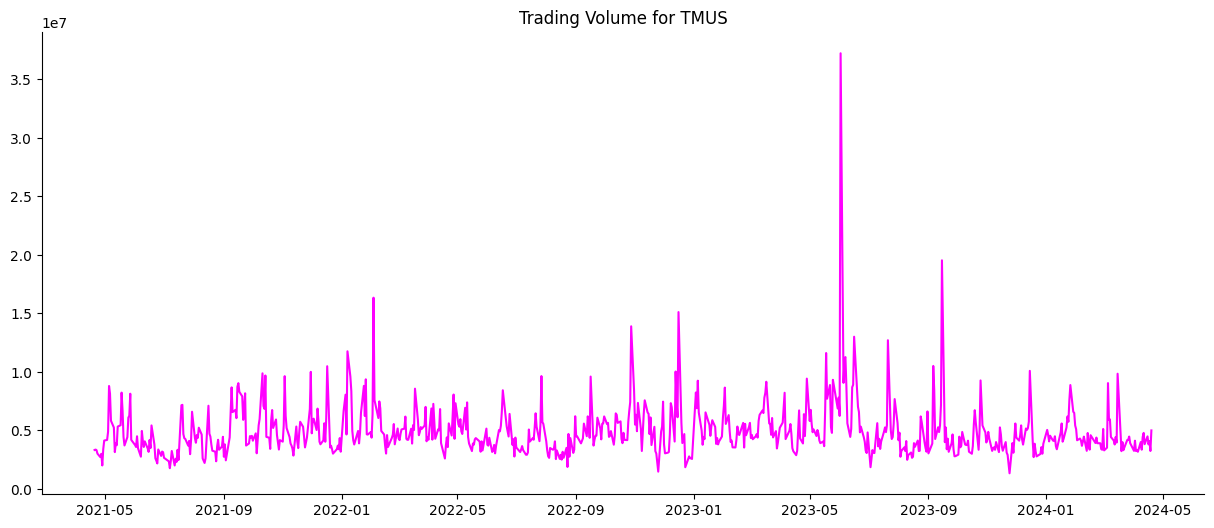

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,6))
plt.plot(data.index, data['Volume'], color = 'magenta')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Trading Volume for TMUS')
plt.show()

Even from the visualation, it is difficult to estimate if weak-stationarity actually holds because of the uncommon spikes in trading volumes. Instead of relying on a visualization, we can utilize the __Augmented Dickey-Fuller__ test, which is a statistical test for weak stationarity. If the p-value is less than 0.05, it indicates stationarity.

In [17]:
from statsmodels.tsa.stattools import adfuller
adfuller(data['Volume'])

(-10.7767093602203,
 2.3098802093799655e-19,
 2,
 753,
 {'1%': -3.4390641198617864,
  '5%': -2.8653859408474482,
  '10%': -2.5688179819544312},
 23465.20297549742)

Since the ADF p-value implies stationarity at 1% percent significance, we can go on with fitting an AR model. To check the predictive performance of our soon-to-be fitted model, i will use a portion of the time-series.

In [27]:
subset = data['Volume'].iloc[:500]

To determine the order p of an AR model, it's useful to look at the __Partial Auto-Correlation Function (PACF)__ plot. The __Auto-Correlation Function (ACF)__ is another important diagnostic plot, but it is often used to cehck the order of other time-series models. The Partial autocorrelation tells us the direct relationship between a specific time point in a time series and its lagged values, while not worrying about influence of the other lagged values up to that lag. In other words...

$$
\text{Partial Autocorrelation for lag k} = Corr(r_{t}, r_{t - k} | r_{t-1}, r_{t-2}, \cdots, r_{t - k + 1})
$$

Since an AR(p) model is essentially a regression on the p past values, the partial autocorrelation for any lag beyond p should be 0. Therefore, to determine the order of our AR model, we should examine the PACF plot and see where the PACF values abruptly become insignificant.
- Side Note: It's assumed that the sample PACF value we get is a normally distributed value with mean 0 and asymptotic variance 1/T where T is the number of values in the time-series.

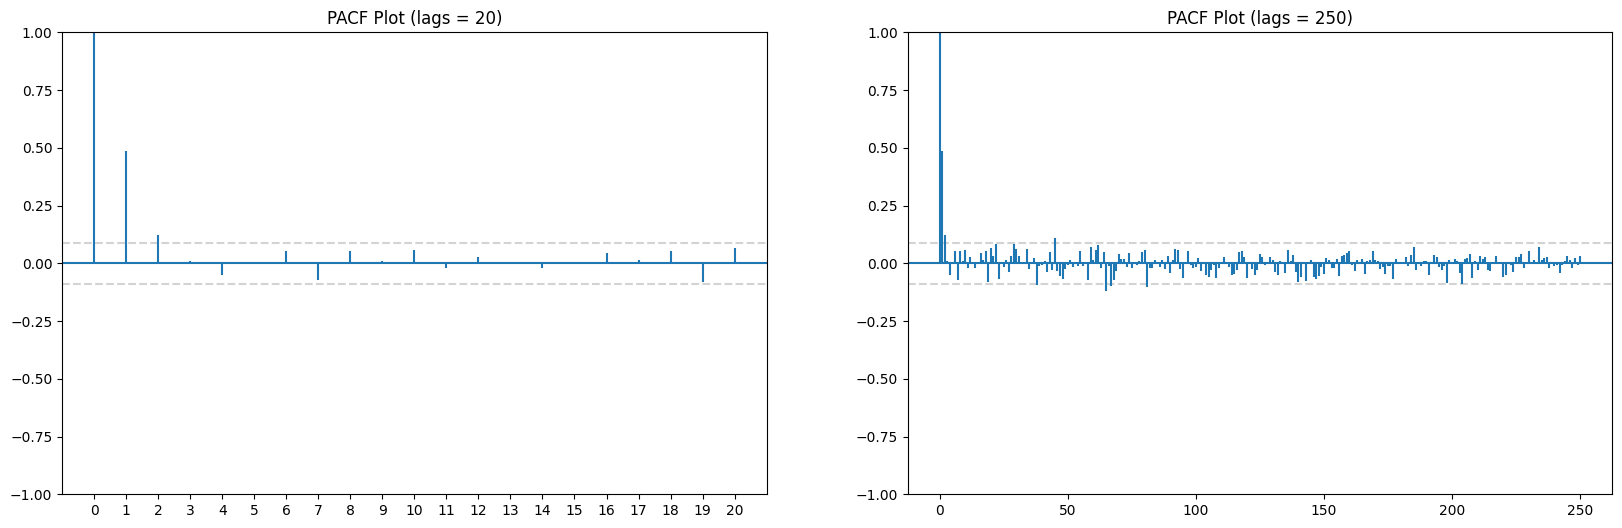

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

T = len(subset)

fig, ax = plt.subplots(1,2,figsize = (20,6))

ax[0].axhline(1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
ax[0].axhline(-1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
plot_pacf(subset, marker = 'None', lags = 20, alpha = 0, ax = ax[0])
ax[0].set_xticks(range(21))
ax[0].set_title('PACF Plot (lags = 20)')

ax[1].axhline(1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
ax[1].axhline(-1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
plot_pacf(subset, marker = 'None', alpha = 0, lags = T/2, ax = ax[1])
ax[1].set_title('PACF Plot (lags = 250)')

plt.show()


Visually, it seems that the order of our AR(p) model should be 2, since the PACFs become insignificant after lag 2. There are some spikes at further lags, but that is probably due to sampling error. If we want to make sure that 2 is the best lag to use, we can utilize python's __ar_select_order__ function. This examines the AIC (goodness of fit criterion) for every AR(p) model up to a specificied lag max.

In [35]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
selector = ar_select_order(subset.values, 200)
print(selector.ar_lags)
print(f'Therefore best lag for AR(p) is p = {np.max(selector.ar_lags)}')


[1, 2]
Therefore best lag for AR(p) is p = 2


After deciding the number of lags we want to use, we can now fit an AR model using python's __ARIMA__ model. This takes in 3 parameters: p (the auto-regressive order), d (the differencing order), and q (the moving average order). Since we are only fitting an AR(2) model, our order will be (2, 0, 0).

In [70]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(subset.values, order=(2, 0, 0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7853.717
Date:                Mon, 22 Apr 2024   AIC                          15715.433
Time:                        02:36:21   BIC                          15732.292
Sample:                             0   HQIC                         15722.049
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.935e+06   1.72e+05     28.620      0.000     4.6e+06    5.27e+06
ar.L1          0.4257      0.036     11.671      0.000       0.354       0.497
ar.L2          0.1229      0.040      3.042      0.0

Currently, the model summary is telling us that {r<sub>t</sub>} is modeled by the following equation...
$$
r_{t} = 4953000 + 0.4257(r_{t-1}) + 0.1229(r_{t-2}) + \epsilon_{t} 
$$
Where &epsilon; is assumed to be a white-noise process with mean 0 and variance 2.579e12 (big variance I know).

Now, we can see how well our AR(2) model performs. To do this, I will use the first 2 values of the time-series, and then use the __predict__ function to forecast the remainder of the time series. With this function, unless specificed otherwise, each forecasted point is based only on the past __actual__ values, not on the model's own forecasted values. This is what makes a potential forecast look 'too good to be true'.

In [54]:
forecast_function = model.predict(start = 2, end = len(subset) - 1)
forecast_function_values = np.append(subset[:2].values, forecast_function)

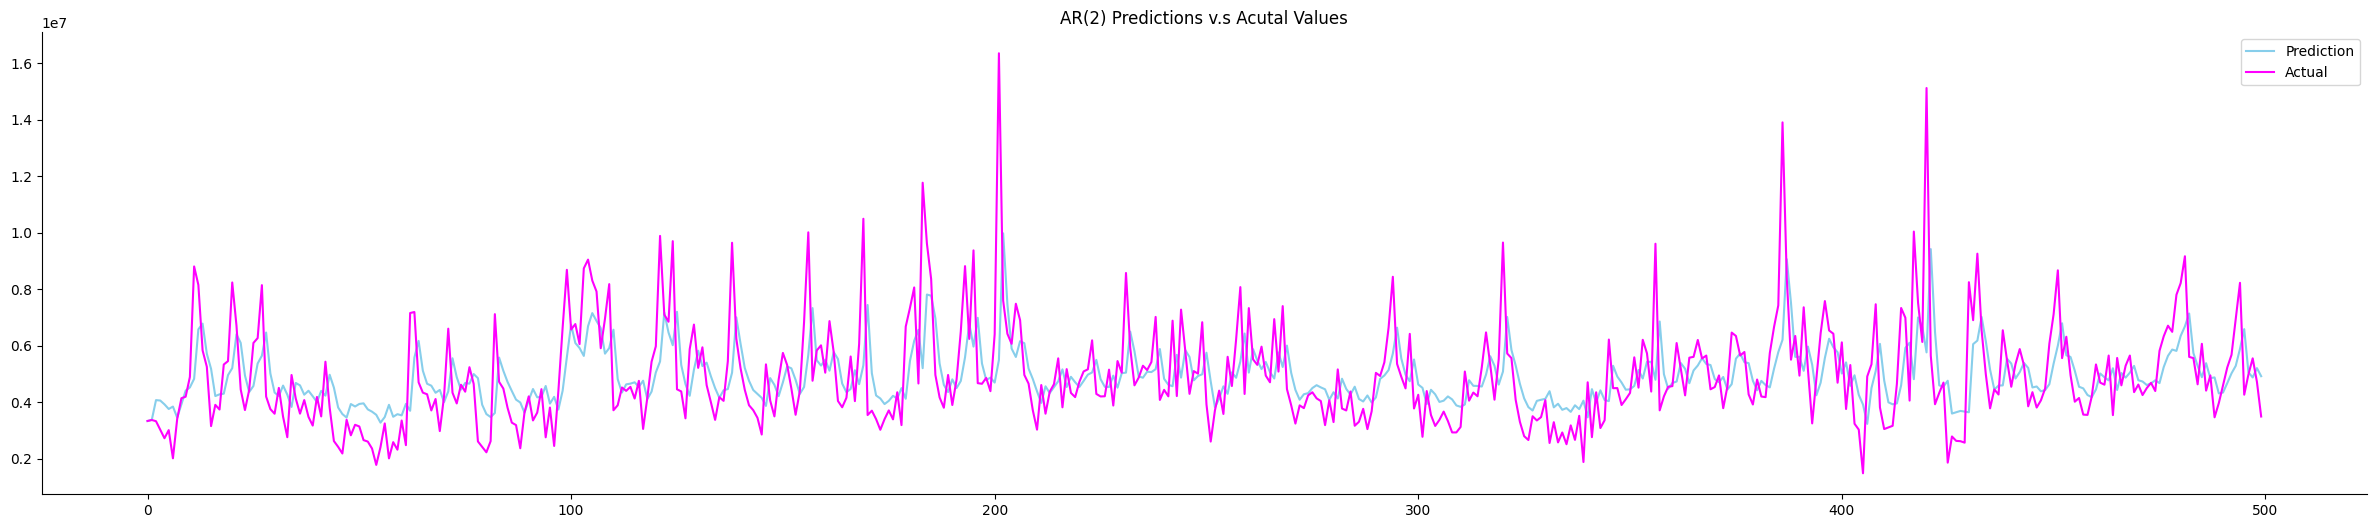

In [59]:
figure = plt.figure(figsize = (30,6))
plt.plot(range(len(forecast_function_values)), forecast_function_values, color = 'skyblue', label = 'Prediction')
plt.plot(range(len(subset)), subset, color = 'magenta', label = 'Actual')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('AR(2) Predictions v.s Acutal Values')
plt.show()

So far, we have only assumed that our residuals are white noise, but we can actually check to make sure that the assumption holds true. For this, we can utilize the ACF plot. For a process to be white noise, there should be no autocorrelations at any lag.

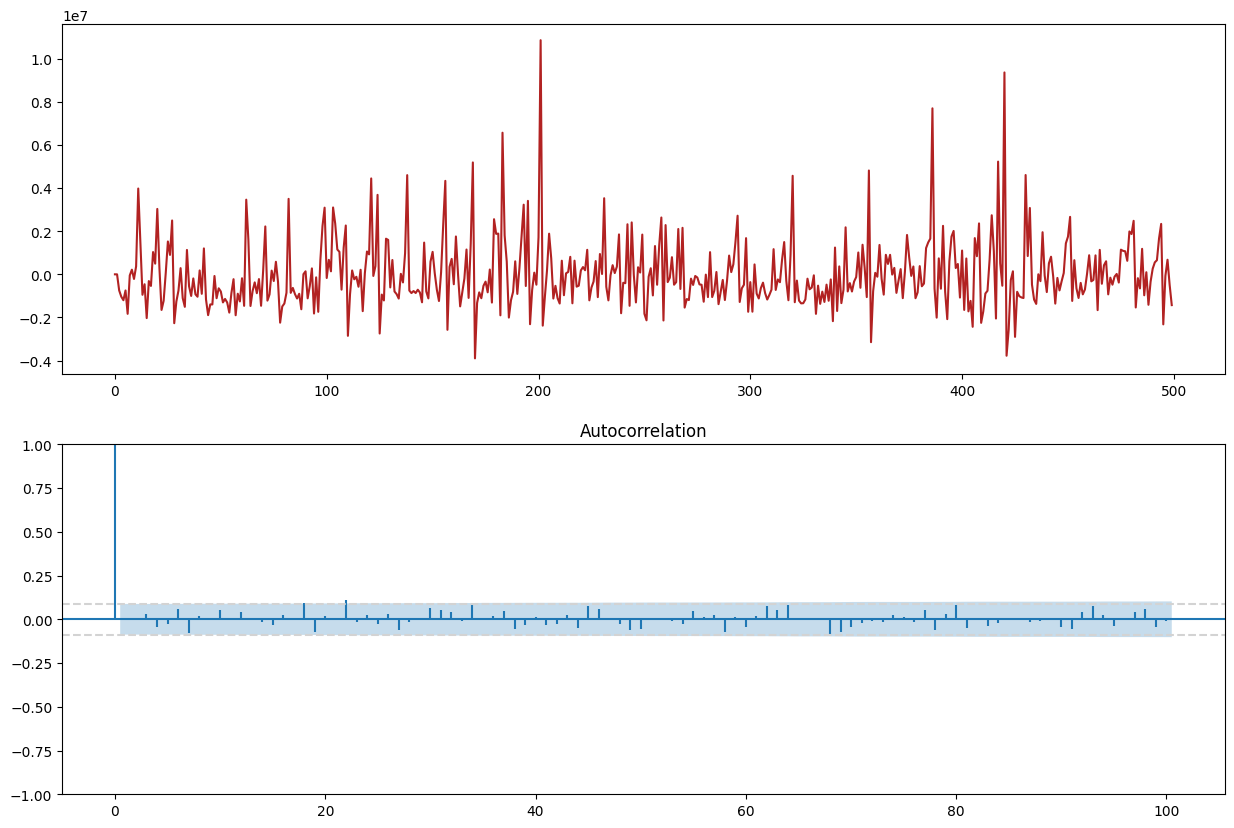

In [61]:
residuals = subset - forecast_function_values

fig, axs = plt.subplots(2, 1, figsize = (15,10))

axs[0].plot(range(len(residuals)), residuals, color = 'firebrick')
plot_acf(residuals, ax = axs[1], lags = 100, marker = None)
axs[1].axhline(1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
axs[1].axhline(-1.96 / np.sqrt(T), color = 'lightgray', linestyle = '--')
plt.show()

By looking at the Autocorrelation plot of our residuals, we can assume that we have a White Noise Process. If we want to truly make sure, we can utilize the __Ljung-Box test__, which tests for autocorrelations up to a sppecific lag.

In [64]:
from statsmodels.stats.diagnostic import acorr_ljungbox

WN_test = acorr_ljungbox(residuals, lags = len(subset) // 2)
WN_test

,lb_stat,lb_pvalue
1,0.003175,0.955062
2,0.003406,0.998299
3,0.444642,0.930874
4,1.513272,0.824288
5,1.915322,0.860733
...,...,...
246,257.730786,0.290944
247,259.253337,0.283552
248,265.082932,0.217730
249,267.329167,0.202783


From here, we can just check for p-values less than 0.05, which indicate presence of autocorrelation up to that lag.

In [65]:
WN_test[WN_test['lb_pvalue'] < 0.05]

,lb_stat,lb_pvalue


The Ljung-Box Test confirms that we have a white noise process (if we check up to lag 250, which is reasonable).

One thing to note about our White Noise process is that we can't assume that it's Gaussian (normally distributed). White Noise does not necessarily mean that the process is normal, it just means that it has mean 0 and finite variance, along with no autocorrelations. We can use a Kernel Density Estimate plot to visualize the distribution of our residuals.

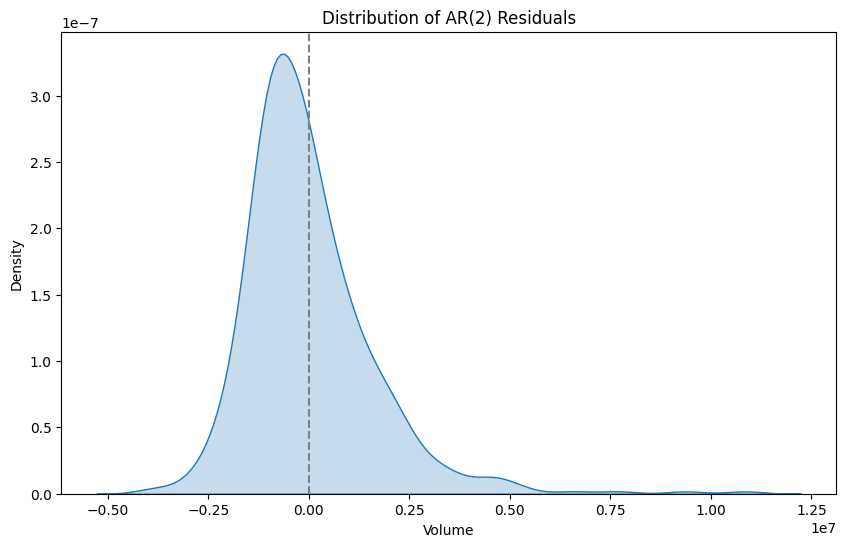

In [67]:
# Visualize the dsitribution of our white noise terms
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize = (10,6))
sns.kdeplot(residuals, fill = True, ax = ax)
ax.axvline(np.mean(residuals), color = 'gray', linestyle = '--')
ax.set_title('Distribution of AR(2) Residuals')
plt.show()

Clearly, we don't have Gaussian White Noise (GWN), but we definetely have White Noise.

From here, we can utilize test metrics to determine the overall strength of our model. I'm only testing the metrics behond t = 2, since we used the first 2 values to make our predictions in the first place.

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = subset[2:]
y_pred = forecast_function_values[2:]

mse = mean_squared_error(y_pred, y_true)
mae = mean_absolute_error(y_pred, y_true)
mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}')

Mean Squared Error: 2578986024546.236
Root Mean Squared Error: 1605922.1726304907
Mean Absolute Error: 1142421.5034522738
Mean Absolute Percentage Error: 24.138337836913507


Overall, a MAPE for 24% is rather high. However, this makes sense because an AR model is very simple, and the dyanmics of trading volume are much more complex than what an AR model says it is.